In [162]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np

In [163]:
training_data = pd.read_csv("data/training.csv")
training_data.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


In [164]:
id_cols = ['TransactionId', 'SubscriptionId', 'BatchId', 'AccountId','CustomerId','ProductId','ProviderId','ChannelId']
for col in id_cols:
    training_data[col] = training_data[col].apply(lambda x : x.split("_")[-1])

training_data.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,76871,36123,3957,887,4406,UGX,256,6,10,airtime,3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,73770,15642,4841,3829,4406,UGX,256,4,6,financial_services,2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,26203,53941,4229,222,4683,UGX,256,6,1,airtime,3,500.0,500,2018-11-15T02:44:21Z,2,0
3,380,102363,648,2185,988,UGX,256,1,21,utility_bill,3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,28195,38780,4841,3829,988,UGX,256,4,6,financial_services,2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [165]:
training_data.set_index('TransactionId')
training_data.nunique()
training_data.dtypes

TransactionId            object
BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
CurrencyCode             object
CountryCode               int64
ProviderId               object
ProductId                object
ProductCategory          object
ChannelId                object
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object

In [166]:
training_data.drop(['CurrencyCode','CountryCode'],axis = 1, inplace=True)
training_data.set_index('TransactionId')

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
TransactionId,,,,,,,,,,,,,
76871,36123,3957,887,4406,6,10,airtime,3,1000.0,1000,2018-11-15T02:18:49Z,2,0
73770,15642,4841,3829,4406,4,6,financial_services,2,-20.0,20,2018-11-15T02:19:08Z,2,0
26203,53941,4229,222,4683,6,1,airtime,3,500.0,500,2018-11-15T02:44:21Z,2,0
380,102363,648,2185,988,1,21,utility_bill,3,20000.0,21800,2018-11-15T03:32:55Z,2,0
28195,38780,4841,3829,988,4,6,financial_services,2,-644.0,644,2018-11-15T03:34:21Z,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89881,96668,4841,3829,3078,4,6,financial_services,2,-1000.0,1000,2019-02-13T09:54:09Z,2,0
91597,3503,3439,2643,3874,6,10,airtime,3,1000.0,1000,2019-02-13T09:54:25Z,2,0
82501,118602,4841,3829,3874,4,6,financial_services,2,-20.0,20,2019-02-13T09:54:35Z,2,0


In [167]:

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(training_data["ProductCategory"].values.reshape(-1,1)))
OH_cols_train.rename(columns=lambda x: "ProductCategory_" + str(x), inplace=True)
# One-hot encoding removed index; put it back
OH_cols_train.index = training_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_train = training_data.drop("ProductCategory", axis=1)


# Add one-hot encoded columns to numerical features
OH_train = pd.concat([num_train, OH_cols_train], axis=1)

# Ensure all columns have string type
OH_train.columns = OH_train.columns.astype(str)

OH_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,Amount,Value,...,FraudResult,ProductCategory_0,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8
0,76871,36123,3957,887,4406,6,10,3,1000.0,1000,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,73770,15642,4841,3829,4406,4,6,2,-20.0,20,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26203,53941,4229,222,4683,6,1,3,500.0,500,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,380,102363,648,2185,988,1,21,3,20000.0,21800,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28195,38780,4841,3829,988,4,6,2,-644.0,644,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
OH_train.drop(["TransactionStartTime"] ,axis = 1, inplace=True)
OH_train.describe()
OH_train = OH_train.apply(pd.to_numeric,errors = "coerce")
X = OH_train.copy()

y = X.pop('FraudResult')

discrete_features = X.dtypes 
discrete_features

TransactionId          int64
BatchId                int64
AccountId              int64
SubscriptionId         int64
CustomerId             int64
ProviderId             int64
ProductId              int64
ChannelId              int64
Amount               float64
Value                  int64
PricingStrategy        int64
ProductCategory_0    float64
ProductCategory_1    float64
ProductCategory_2    float64
ProductCategory_3    float64
ProductCategory_4    float64
ProductCategory_5    float64
ProductCategory_6    float64
ProductCategory_7    float64
ProductCategory_8    float64
dtype: object

In [169]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features="auto")
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  

PricingStrategy      0.016363
ChannelId            0.011410
SubscriptionId       0.009466
ProductCategory_0    0.005836
ProductCategory_3    0.000346
ProductCategory_4    0.000134
ProductCategory_5    0.000000
Name: MI Scores, dtype: float64

In [170]:
X.describe()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,Amount,Value,PricingStrategy,ProductCategory_0,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8
count,95662.000000,95662.000000,95662.000000,95662.000000,95662.000000,95662.000000,95662.000000,95662.000000,9.566200e+04,9.566200e+04,95662.000000,95662.000000,95662.000000,95662.000000,95662.000000,95662.000000,95662.000000,95662.000000,95662.000000,95662.000000
mean,70334.481581,70526.339173,3361.571648,3023.115845,3126.883590,4.657157,7.419069,2.622410,6.717846e+03,9.900584e+03,2.255974,0.470688,0.016861,0.474640,0.001829,0.000021,0.002258,0.000261,0.013370,0.020071
std,40626.774116,40586.254942,1560.040065,1293.973071,1650.972455,1.309014,4.655919,0.558568,1.233068e+05,1.231221e+05,0.732924,0.499143,0.128753,0.499359,0.042732,0.004572,0.047464,0.016164,0.114854,0.140243
min,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,-1.000000e+06,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35235.250000,35468.500000,2203.000000,2067.000000,1875.000000,4.000000,3.000000,2.000000,-5.000000e+01,2.750000e+02,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,70319.500000,70614.000000,3919.000000,3829.000000,3124.000000,5.000000,6.000000,3.000000,1.000000e+03,1.000000e+03,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,105542.750000,105627.750000,4841.000000,3829.000000,4229.000000,6.000000,10.000000,3.000000,2.800000e+03,5.000000e+03,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,140681.000000,139493.000000,4841.000000,4836.000000,7479.000000,6.000000,27.000000,5.000000,9.880000e+06,9.880000e+06,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


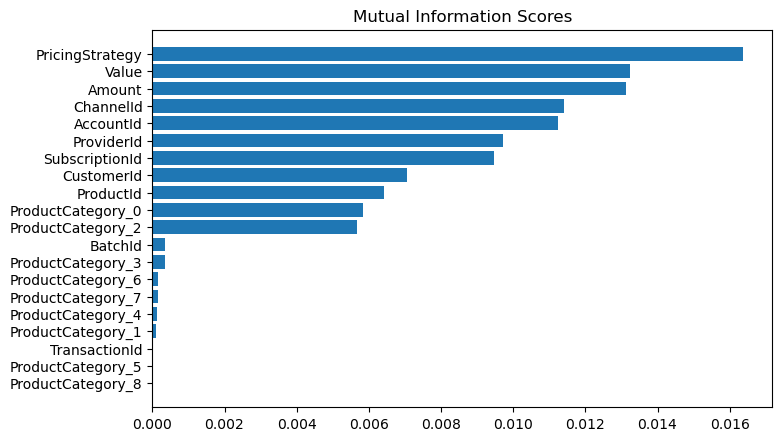

In [172]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)